# EfficientDet building for DF2

### Connecting to DF2

In [1]:
import boto3
import os
import pandas as pd
import json, csv
import matplotlib.image as img
from PIL import Image

In [2]:
# Setting up connection to DF2 bucket
bucket = 'descriptiveworld-datasets'
subfolder = 'DeepFashion2/'

In [3]:
from sagemaker import get_execution_role
role = get_execution_role()

In [4]:
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

ClientError: An error occurred (AccessDenied) when calling the ListObjects operation: Access Denied

### Importing json for training set

In [5]:
os.getcwd()

'/home/ec2-user/SageMaker'

In [9]:
# orig_file = 'DeepFashion2/train/train.json'
# dest_file = '/home/ec2-user/SageMaker/train.json'

# # Connect to S3 bucket and download file - train.json
# s3 = boto3.resource('s3')
# s3.Bucket(bucket).download_file(orig_file, dest_file)

In [6]:
# Reading in json
train_df = pd.read_json("train.json")

In [7]:
train_df.head()

,item2,source,pair_id,item3,item4,item6,item5,item8,item7,img,segmentation,scale,viewpoint,zoom_in,landmarks,style,bounding_box,category_id,occlusion,category_name
0,"{'segmentation': [[460, 438, 374, 484, 251, 52...",user,1,None,None,None,None,None,None,000001.jpg,"[[257, 35, 261, 89, 228, 123, 137, 103, 45, 91...",3,2,2,"[182, 54, 1, 45, 91, 1, 137, 103, 1, 228, 123,...",1,"[0, 29, 466, 622]",1,2,short sleeve top
1,"{'segmentation': [[220.25, 187.55, 259.6, 177....",shop,1,None,None,None,None,None,None,000002.jpg,"[[145.21, 314.0, 162.67, 312.8, 175.12, 313.05...",3,2,2,"[127, 335, 1, 73, 340, 1, 107, 354, 1, 140, 35...",1,"[1, 300, 367, 701]",1,2,short sleeve top
2,None,user,2,None,None,None,None,None,None,000003.jpg,"[[338, 64, 299, 133, 228, 189, 183, 121, 160, ...",3,1,2,"[240, 108, 2, 160, 63, 2, 183, 121, 2, 228, 18...",1,"[1, 52, 467, 831]",11,1,long sleeve dress
3,None,user,2,None,None,None,None,None,None,000004.jpg,"[[266, 160, 257, 191, 233, 218, 184, 210, 149,...",3,2,2,"[223, 187, 1, 149, 190, 2, 184, 210, 2, 233, 2...",1,"[0, 113, 467, 623]",11,1,long sleeve dress
4,None,user,2,None,None,None,None,None,None,000005.jpg,"[[204.0, 143.0, 182.0, 137.0, 167.0, 130.0, 16...",3,1,2,"[205, 143, 2, 162, 129, 2, 192, 164, 2, 222, 1...",1,"[1, 98, 467, 814]",11,1,long sleeve dress


In [8]:
# Making a subset of the dataframe for testing
train_columns = ['img', 'category_name', "bounding_box"]
train_sub = train_df.loc[:, train_columns]
train_sub.head()

,img,category_name,bounding_box
0,000001.jpg,short sleeve top,"[0, 29, 466, 622]"
1,000002.jpg,short sleeve top,"[1, 300, 367, 701]"
2,000003.jpg,long sleeve dress,"[1, 52, 467, 831]"
3,000004.jpg,long sleeve dress,"[0, 113, 467, 623]"
4,000005.jpg,long sleeve dress,"[1, 98, 467, 814]"


In [9]:
# Testing only a handfull of labels
short_list = ['short sleeve top', 'trousers', 'long sleeve top', 'short sleeve dress']
train_short = train_sub[train_sub.category_name.isin(short_list)]
train_short.groupby('category_name').count()['img']

category_name
long sleeve top       25085
short sleeve dress    16706
short sleeve top      53914
trousers              23250
Name: img, dtype: int64

### Preparing training images by making folders on local drive

In [ ]:
if not os.path.exists('effdet_df2'):
    os.mkdir('effdet_df2')
if not os.path.exists('effdet_df2/train'):
    os.mkdir('effdet_df2/train')
if not os.path.exists('effdet_df2/val'):
    os.mkdir('effdet_df2/val')

In [10]:
train_short_sub = train_short.groupby('category_name').sample(n=5000, random_state=5)
train_short_sub.groupby('category_name').count()

,img,bounding_box
category_name,,
long sleeve top,5000,5000
short sleeve dress,5000,5000
short sleeve top,5000,5000
trousers,5000,5000


In [11]:
train_short_sub.head()

,img,category_name,bounding_box
22276,022277.jpg,long sleeve top,"[217, 32, 614, 342]"
7026,007027.jpg,long sleeve top,"[192, 311, 605, 771]"
102933,102935.jpg,long sleeve top,"[152, 135, 592, 393]"
23657,023658.jpg,long sleeve top,"[11, 0, 463, 824]"
149394,149403.jpg,long sleeve top,"[87, 169, 173, 232]"


In [12]:
train_list = list(train_short_sub['img'])
train_list[:5]

['022277.jpg', '007027.jpg', '102935.jpg', '023658.jpg', '149403.jpg']

In [15]:
# # transferring images from s3 to local
# s3 = boto3.resource('s3')

# for image in train_list:
#     orig_img = 'DeepFashion2/train/image/' + image
#     dest_img = '/home/ec2-user/SageMaker/effdet_df2/train/' + image
    
#     # Connect to S3 bucket and download image
#     s3.Bucket(bucket).download_file(orig_img, dest_img)

In [13]:
temp_list = os.listdir('./effdet_df2/train')
print(len(temp_list))

20000


### Setting up dataset for training

In [14]:
# Making columns for the bounding box coordinates
train_short_sub[['x1', 'y1', 'x2', 'y2']] = pd.DataFrame(
    train_short_sub.bounding_box.tolist(), index=train_short_sub.index)
train_short_sub.drop(columns=["bounding_box"], inplace=True)
train_short_sub.head()

,img,category_name,x1,y1,x2,y2
22276,022277.jpg,long sleeve top,217,32,614,342
7026,007027.jpg,long sleeve top,192,311,605,771
102933,102935.jpg,long sleeve top,152,135,592,393
23657,023658.jpg,long sleeve top,11,0,463,824
149394,149403.jpg,long sleeve top,87,169,173,232


In [15]:
# determine the dimensions of each image
dims = []
for file in list(train_short_sub['img']):
    i = Image.open('./effdet_df2/train/'+file)
    dims.append([*i.size])
dims_df = pd.DataFrame(dims, columns=['i_w', 'i_h'])

In [16]:
most_common_w = dims_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
most_common_h = dims_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(most_common_w)
print(most_common_h)

      i_h
i_w      
468  7471
      i_w
i_h      
624  2697


In [17]:
train_short_sub = pd.concat([train_short_sub.reset_index(drop=True), dims_df.reset_index(drop=True)], axis=1)

In [18]:
IMG_DIM = 300

In [19]:
# determine which images are outside the range of the image dim
toosmall = train_short_sub[(train_short_sub['i_w'] < IMG_DIM) | (train_short_sub['i_h'] < IMG_DIM)]
print(len(toosmall))

373


In [20]:
# Removing small images
train_short_sub = train_short_sub[~train_short_sub.img.isin(toosmall.img)]
train_short_sub.head()

,img,category_name,x1,y1,x2,y2,i_w,i_h
0,022277.jpg,long sleeve top,217,32,614,342,687,621
1,007027.jpg,long sleeve top,192,311,605,771,750,1125
2,102935.jpg,long sleeve top,152,135,592,393,750,500
3,023658.jpg,long sleeve top,11,0,463,824,468,832
5,138296.jpg,long sleeve top,0,4,466,623,468,624


In [21]:
train_short_sub.groupby('category_name').count()['img']

category_name
long sleeve top       4907
short sleeve dress    4851
short sleeve top      4906
trousers              4963
Name: img, dtype: int64

In [59]:
# Making all remaining class images the same length
train_test = train_short_sub.groupby('category_name').sample(n=3000, random_state=5)
train_test.head()

,img,category_name,x1,y1,x2,y2,i_w,i_h
3040,092400.jpg,long sleeve top,221,357,525,691,750,1125
3608,142068.jpg,long sleeve top,0,91,375,682,424,756
513,128992.jpg,long sleeve top,319,177,624,506,750,588
2595,121091.jpg,long sleeve top,7,0,510,502,640,640
4743,170517.jpg,long sleeve top,159,271,466,623,468,624


In [60]:
train_test['path'] = train_test['img'].apply(lambda x: 'home/ec2-user/SageMaker/effdet_df2/train/' + x)

In [24]:
train_test["x3"] = ""
train_test.head()

,img,category_name,x1,y1,x2,y2,i_w,i_h,path,x3
3040,092400.jpg,long sleeve top,221,357,525,691,750,1125,home/ec2-user/SageMaker/effdet_df2/train/09240...,
3608,142068.jpg,long sleeve top,0,91,375,682,424,756,home/ec2-user/SageMaker/effdet_df2/train/14206...,
513,128992.jpg,long sleeve top,319,177,624,506,750,588,home/ec2-user/SageMaker/effdet_df2/train/12899...,
2595,121091.jpg,long sleeve top,7,0,510,502,640,640,home/ec2-user/SageMaker/effdet_df2/train/12109...,
4743,170517.jpg,long sleeve top,159,271,466,623,468,624,home/ec2-user/SageMaker/effdet_df2/train/17051...,


In [25]:
train_test["y3"] = ""
train_test["x4"] = ""
train_test["y4"] = ""

In [61]:
train_test_lab = train_test.loc[:, ['path', "x1", 'y1', 'x2', 'y2', 'category_name']]

In [62]:
train_test_lab.head()

,path,x1,y1,x2,y2,category_name
3040,home/ec2-user/SageMaker/effdet_df2/train/09240...,221,357,525,691,long sleeve top
3608,home/ec2-user/SageMaker/effdet_df2/train/14206...,0,91,375,682,long sleeve top
513,home/ec2-user/SageMaker/effdet_df2/train/12899...,319,177,624,506,long sleeve top
2595,home/ec2-user/SageMaker/effdet_df2/train/12109...,7,0,510,502,long sleeve top
4743,home/ec2-user/SageMaker/effdet_df2/train/17051...,159,271,466,623,long sleeve top


In [63]:
train_test_lab.to_csv("/home/ec2-user/SageMaker/effdet_train.csv", index=False, header=False)

### Preparing validation data

In [45]:
# orig_file = 'DeepFashion2/validation/validation.json'
# dest_file = '/home/ec2-user/SageMaker/validation.json'

# # Connect to S3 bucket and download file - train.json
# s3 = boto3.resource('s3')
# s3.Bucket(bucket).download_file(orig_file, dest_file)

In [30]:
# Reading in json
val_df = pd.read_json("validation.json")

In [31]:
val_sub = val_df.loc[:, train_columns]
val_sub.head()

,img,category_name,bounding_box
0,000001.jpg,vest,"[199, 190, 287, 269]"
1,000002.jpg,vest,"[170, 121, 280, 215]"
2,000003.jpg,short sleeve dress,"[151, 241, 279, 435]"
3,000004.jpg,short sleeve dress,"[174, 205, 327, 393]"
4,000005.jpg,short sleeve top,"[48, 0, 467, 623]"


In [32]:
val_short = val_sub[val_sub.category_name.isin(short_list)]
val_short.groupby('category_name').count()['img']

category_name
long sleeve top       4414
short sleeve dress    3026
short sleeve top      9603
trousers              2792
Name: img, dtype: int64

In [33]:
val_short_sub = val_short.groupby('category_name').sample(n=2000, random_state=5)
val_short_sub.groupby('category_name').count()

,img,bounding_box
category_name,,
long sleeve top,2000,2000
short sleeve dress,2000,2000
short sleeve top,2000,2000
trousers,2000,2000


In [34]:
val_list = list(val_short_sub['img'])
val_list[:5]

['001465.jpg', '005883.jpg', '030278.jpg', '010727.jpg', '028952.jpg']

In [40]:
# s3 = boto3.resource('s3')

# for image in val_list:
#     orig_img = 'DeepFashion2/validation/image/' + image
#     dest_img = '/home/ec2-user/SageMaker/effdet_df2/val/' + image
    
#     # Connect to S3 bucket and download image
#     s3.Bucket(bucket).download_file(orig_img, dest_img)

In [35]:
temp_list = os.listdir('./effdet_df2/val')
print(len(temp_list))

8000


In [36]:
# Making columns for the bounding box coordinates
val_short_sub[['x1', 'y1', 'x2', 'y2']] = pd.DataFrame(
    val_short_sub.bounding_box.tolist(), index=val_short_sub.index)
val_short_sub.drop(columns=["bounding_box"], inplace=True)
val_short_sub.head()

,img,category_name,x1,y1,x2,y2
1464,001465.jpg,long sleeve top,1,45,466,623
5882,005883.jpg,long sleeve top,0,0,433,614
30277,030278.jpg,long sleeve top,327,129,548,448
10726,010727.jpg,long sleeve top,0,36,467,369
28951,028952.jpg,long sleeve top,208,121,444,431


In [37]:
val_dim = []
for file in list(val_short_sub['img']):
    i = Image.open('./effdet_df2/val/'+file)
    val_dim.append([*i.size])
val_dim_df = pd.DataFrame(val_dim, columns=['i_w', 'i_h'])

In [38]:
val_w = val_dim_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
val_h = val_dim_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(val_w)
print(val_h)

      i_h
i_w      
468  3190
      i_w
i_h      
624  1108


In [39]:
val_short_sub = pd.concat([val_short_sub.reset_index(drop=True), val_dim_df.reset_index(drop=True)], axis=1)

In [40]:
toosmall_val = val_short_sub[(val_short_sub['i_w'] < IMG_DIM) | (val_short_sub['i_h'] < IMG_DIM)]
print(len(toosmall_val))

117


In [41]:
val_short_sub = val_short_sub[~val_short_sub.img.isin(toosmall_val.img)]
val_short_sub.head()

,img,category_name,x1,y1,x2,y2,i_w,i_h
0,001465.jpg,long sleeve top,1,45,466,623,468,624
1,005883.jpg,long sleeve top,0,0,433,614,468,624
2,030278.jpg,long sleeve top,327,129,548,448,880,587
3,010727.jpg,long sleeve top,0,36,467,369,468,624
4,028952.jpg,long sleeve top,208,121,444,431,640,432


In [42]:
val_short_sub.groupby('category_name').count()['img']

category_name
long sleeve top       1974
short sleeve dress    1957
short sleeve top      1975
trousers              1977
Name: img, dtype: int64

In [64]:
val_test = val_short_sub.groupby('category_name').sample(n=500, random_state=5)
val_test.head()

,img,category_name,x1,y1,x2,y2,i_w,i_h
1697,027129.jpg,long sleeve top,305,232,654,556,880,557
938,020098.jpg,long sleeve top,133,2,464,455,640,497
422,022818.jpg,long sleeve top,135,259,542,898,750,951
834,009767.jpg,long sleeve top,1,137,466,623,468,624
1357,002970.jpg,long sleeve top,21,9,467,443,468,624


In [65]:
val_test['path'] = val_test['img'].apply(lambda x: 'home/ec2-user/SageMaker/effdet_df2/val/' + x)

In [45]:
val_test["x3"] = ""
val_test["y3"] = ""
val_test["x4"] = ""
val_test["y4"] = ""

In [66]:
val_test_lab = val_test.loc[:, ['path', 'x1', 'y1', 'x2', 'y2', 'category_name']]

In [67]:
val_test_lab.to_csv("/home/ec2-user/SageMaker/effdet_val.csv", index=False, header=False)

## Making Class map file

In [1]:
class_list = ['short sleeve top', 'trousers', 'long sleeve top', 'short sleeve dress']

In [5]:
class_num = list(range(0, len(class_list)))

[0, 1, 2, 3]

In [6]:
class_df = pd.DataFrame(list(zip(class_list, class_num)))
class_df

,0,1
0,short sleeve top,0
1,trousers,1
2,long sleeve top,2
3,short sleeve dress,3


In [7]:
class_df.to_csv("/home/ec2-user/SageMaker/classes.csv", index=False, header=False)

# Preparing the EfficientDet model

In [8]:
# Downloading the github project for EfficientDet
!git clone https://github.com/xuannianz/EfficientDet

Cloning into 'EfficientDet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 1.50 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [48]:
os.chdir('./EfficientDet')

In [49]:
os.getcwd()

'/home/ec2-user/SageMaker/EfficientDet'

In [50]:
!pip3 install keras_applications

     |████████████████████████████████| 50 kB 4.5 MB/s eta 0:00:011


In [51]:
from datetime import date
import os
import sys
import tensorflow as tf

In [52]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD

from augmentor.color import VisualEffect
from augmentor.misc import MiscEffect
from model import efficientdet
from losses import smooth_l1, focal, smooth_l1_quad
from efficientnet import BASE_WEIGHTS_PATH, WEIGHTS_HASHES

In [53]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15754309519806406067
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6593612218255737979
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 215700319328743365
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12355927375365208742
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


In [54]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Hyperparameters

In [69]:
batch_size = 32
phi = 3    # Model size
detect_text = False
snapshot = "imagenet"
gpu = "0"

dataset_type = 'csv'
train_path = "/home/ec2-user/SageMaker/effdet_train.csv"
class_path = "classes.csv"
val_path = "/home/ec2-user/SageMaker/effdet_val.csv"

freeze_backbone = True
compute_val_loss = True
weighted_bifpn = False
freeze_bn = False
tensorboard_dir = 'logs/{}'.format(str(date.today()))
evaluation = True
snapshots_store = True

epochs = 10
NUM_TRAIN = 12000
NUM_TEST = 2000

steps = NUM_TRAIN //batch_size,
val_steps= NUM_TEST //batch_size

workers = 4
dropout_rate = 0.2

### This is from the train.py in the cloned repository

In [70]:
def create_generators(dataset_type, train_path, class_path, batch_size, phi, detect_text,
                      val_path=None, random_transform=None):
    """
    Create generators for training and validation.

        preprocess_image: Function that preprocesses an image for the network.
    """
    common_args = {
        'batch_size': batch_size,
        'phi': phi,
        'detect_text': detect_text,
        'detect_quadrangle': False
    }

    # create random transform generator for augmenting training data
    if random_transform:
        misc_effect = MiscEffect()
        visual_effect = VisualEffect()
    else:
        misc_effect = None
        visual_effect = None

    if dataset_type == 'csv':
        from generators.csv_ import CSVGenerator
        train_generator = CSVGenerator(
            train_path,
            class_path,
            misc_effect=misc_effect,
            visual_effect=visual_effect,
            **common_args
        )
        if val_path:
            validation_generator = CSVGenerator(
                val_path,
                class_path,
                shuffle_groups=False,
                **common_args
            )
        else:
            validation_generator = None

    else:
        raise ValueError('Invalid data type received: {}'.format(dataset_type))

    return train_generator, validation_generator

In [57]:
def create_callbacks(training_model, prediction_model, validation_generator, tensorboard_dir, batch_size,
                    evaluation, snapshots):
    """
    Creates the callbacks to use during training.
    Args
        training_model: The model that is used for training.
        prediction_model: The model that should be used for validation.
        validation_generator: The generator for creating validation data.
        args: parseargs args object.
    Returns:
        A list of callbacks used for training.
    """
    callbacks = []

    tensorboard_callback = None

    if tensorboard_dir:
        if tf.version.VERSION > '2.0.0':
            file_writer = tf.summary.create_file_writer(tensorboard_dir)
            file_writer.set_as_default()
        tensorboard_callback = keras.callbacks.TensorBoard(
            log_dir=tensorboard_dir,
            histogram_freq=0,
            batch_size=batch_size,
            write_graph=True,
            write_grads=False,
            write_images=False,
            embeddings_freq=0,
            embeddings_layer_names=None,
            embeddings_metadata=None
        )
        callbacks.append(tensorboard_callback)

    if evaluation and validation_generator:
        if dataset_type == 'coco':
            from eval.coco import Evaluate
            # use prediction model for evaluation
            evaluation = Evaluate(validation_generator, prediction_model, tensorboard=tensorboard_callback)
        else:
            from eval.pascal import Evaluate
            evaluation = Evaluate(validation_generator, prediction_model, tensorboard=tensorboard_callback)
        callbacks.append(evaluation)

    # save the model
    if snapshots:
        # ensure directory created first; otherwise h5py will error after epoch.
        makedirs(snapshot_path)
        checkpoint = keras.callbacks.ModelCheckpoint(
            os.path.join(
                snapshot_path,
                f'{dataset_type}_{{epoch:02d}}_{{loss:.4f}}_{{val_loss:.4f}}.h5' if compute_val_loss
                else f'{dataset_type}_{{epoch:02d}}_{{loss:.4f}}.h5'
            ),
            verbose=1,
            save_weights_only=True,
            monitor="mAP",
            # mode='max'
        )
        callbacks.append(checkpoint)

    # callbacks.append(keras.callbacks.ReduceLROnPlateau(
    #     monitor='loss',
    #     factor=0.1,
    #     patience=2,
    #     verbose=1,
    #     mode='auto',
    #     min_delta=0.0001,
    #     cooldown=0,
    #     min_lr=0
    # ))

    return callbacks

In [72]:
# create the generators
train_generator, validation_generator = create_generators(dataset_type, train_path, class_path,
                                                          batch_size, phi, detect_text, val_path)

num_classes = train_generator.num_classes()
num_anchors = train_generator.num_anchors

# optionally choose specific GPU
if gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu


model, prediction_model = efficientdet(phi,
                                       num_classes=num_classes,
                                       num_anchors=num_anchors,
                                       weighted_bifpn=weighted_bifpn,
                                       freeze_bn=freeze_bn,
                                       detect_quadrangle=False
                                       )
# load pretrained weights
if snapshot:
    if snapshot == 'imagenet':
        model_name = 'efficientnet-b{}'.format(phi)
        file_name = '{}_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'.format(model_name)
        file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras.utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        model.load_weights(weights_path, by_name=True)
    else:
        print('Loading model, this may take a second...')
        model.load_weights(snapshot, by_name=True)

# freeze backbone layers
if freeze_backbone:
    # 227, 329, 329, 374, 464, 566, 656
    for i in range(1, [227, 329, 329, 374, 464, 566, 656][phi]):
        model.layers[i].trainable = False

if gpu and len(gpu.split(',')) > 1:
    model = keras.utils.multi_gpu_model(model, gpus=list(map(int, gpu.split(','))))

# compile model
model.compile(optimizer=Adam(lr=1e-3), loss={
    'regression': smooth_l1_quad() if detect_quadrangle else smooth_l1(),
    'classification': focal()
}, )

print(model.summary())

# create the callbacks
callbacks = create_callbacks(
    model,
    prediction_model,
    validation_generator,
    tensorboard_dir,
    batch_size,
    evaluation,
    snapshots_store
)

if not compute_val_loss:
    validation_generator = None
elif compute_val_loss and validation_generator is None:
    raise ValueError('When you have no validation data, you should not specify --compute-val-loss.')

ValueError: It appears you are trying to construct a functional model, but not all of the inputs in the first positional argument of your layer call are symbolic tensors. (Input objects, or the output of another layer) Functional models cannot correctly track custom layers unless all values in the first call argument are symbolic.

In [ ]:
# start training
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    workers=workers,
    use_multiprocessing=True,
    validation_data=validation_generator
)

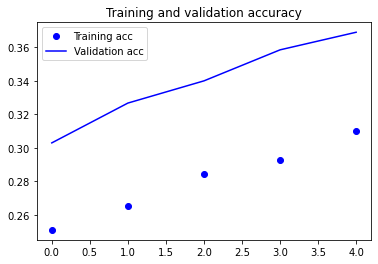

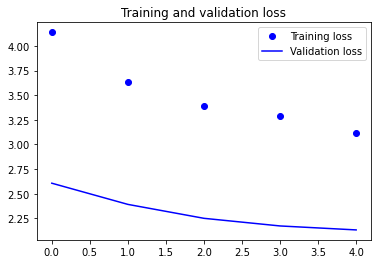

In [19]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
model.save("df2_model_effnet")

INFO:tensorflow:Assets written to: df2_model_effnet/assets
